
<h1><center>APTOS 2019 Blindness Detection</center></h1>
<h2><center>Diabetic retinopathy - SHAP model explainability</center></h2>
![](https://raw.githubusercontent.com/dimitreOliveira/MachineLearning/master/Kaggle/APTOS%202019%20Blindness%20Detection/aux_img.png)

In this work, I'll train a baseline ResNet50, evaluate the model, and use SHAP model explainability technique to help us better understand our model's predictions, and how we could further improve its performance.

#### About [SHAP](https://github.com/slundberg/shap) from its source:

<img src="https://raw.githubusercontent.com/slundberg/shap/master/docs/artwork/shap_diagram.png" width="400">

##### SHAP (SHapley Additive exPlanations) is a unified approach to explain the output of any machine learning model. SHAP connects game theory with local explanations, uniting several previous methods [1-7] and representing the only possible consistent and locally accurate additive feature attribution method based on expectations (see our [papers](https://github.com/slundberg/shap#citations) for details).

## Dependencies

In [1]:
import os
import shap
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from keras.models import Model
from keras import optimizers, applications
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_random_seed(seed)

seed = 0
seed_everything(seed)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


## Load data

In [2]:
train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')
print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])

# Preprocecss data
train["id_code"] = train["id_code"].apply(lambda x: x + ".png")
test["id_code"] = test["id_code"].apply(lambda x: x + ".png")
train['diagnosis'] = train['diagnosis'].astype('str')
display(train.head())

Number of train samples:  3662
Number of test samples:  1928


,id_code,diagnosis
0,000c1434d8d7.png,2
1,001639a390f0.png,4
2,0024cdab0c1e.png,1
3,002c21358ce6.png,0
4,005b95c28852.png,0


# Model parameters

In [3]:
# Model parameters
BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

## Train test split

In [4]:
X_train, X_val = train_test_split(train, test_size=0.2, random_state=seed)

# Data generator

In [5]:
train_datagen=ImageDataGenerator(rescale=1./255, 
                                 rotation_range=360,
                                 horizontal_flip=True,
                                 vertical_flip=True)

train_generator=train_datagen.flow_from_dataframe(
    dataframe=X_train,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    target_size=(HEIGHT, WIDTH),
    seed=0)

validation_datagen = ImageDataGenerator(rescale=1./255)

valid_generator=validation_datagen.flow_from_dataframe(
    dataframe=X_val,
    directory="../input/aptos2019-blindness-detection/train_images/",
    x_col="id_code",
    y_col="diagnosis",
    class_mode="categorical", 
    batch_size=BATCH_SIZE,   
    target_size=(HEIGHT, WIDTH),
    seed=0)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/aptos2019-blindness-detection/test_images/",
        x_col="id_code",
        batch_size=1,
        class_mode=None,
        shuffle=False,
        target_size=(HEIGHT, WIDTH),
        seed=0)

Found 2929 validated image filenames belonging to 5 classes.
Found 733 validated image filenames belonging to 5 classes.
Found 1928 validated image filenames.


# Model

In [6]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights=None, 
                                       include_top=False,
                                       input_tensor=input_tensor)
    base_model.load_weights('../input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    
    return model

# Train top layers

In [7]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
    
class_weights = class_weight.compute_class_weight('balanced', np.unique(train['diagnosis'].astype('int').values), train['diagnosis'].astype('int').values)

metric_list = ["accuracy"]
optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 160, 160, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [8]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,
                                     validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     class_weight=class_weights,
                                     verbose=1).history

Epoch 1/2
366/366 [==============================] - 547s 1s/step - loss: 1.3425 - acc: 0.6281 - val_loss: 1.3861 - val_acc: 0.4821
Epoch 2/2
366/366 [==============================] - 426s 1s/step - loss: 0.8673 - acc: 0.6756 - val_loss: 1.5494 - val_acc: 0.4814


# Fine-tune the complete model

In [9]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy',  metrics=metric_list)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 160, 160, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [10]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          class_weight=class_weights,
                                          verbose=1).history

Epoch 1/40
366/366 [==============================] - 438s 1s/step - loss: 0.7330 - acc: 0.7370 - val_loss: 0.6670 - val_acc: 0.7890
Epoch 2/40
366/366 [==============================] - 423s 1s/step - loss: 0.5993 - acc: 0.7719 - val_loss: 0.6426 - val_acc: 0.8014
Epoch 3/40
366/366 [==============================] - 422s 1s/step - loss: 0.5341 - acc: 0.8012 - val_loss: 0.5685 - val_acc: 0.8138
Epoch 4/40
366/366 [==============================] - 425s 1s/step - loss: 0.5365 - acc: 0.7975 - val_loss: 0.5015 - val_acc: 0.8083
Epoch 5/40
366/366 [==============================] - 422s 1s/step - loss: 0.4708 - acc: 0.8200 - val_loss: 0.6241 - val_acc: 0.7986
Epoch 6/40
366/366 [==============================] - 422s 1s/step - loss: 0.4744 - acc: 0.8214 - val_loss: 0.4716 - val_acc: 0.8166
Epoch 7/40
366/366 [==============================] - 426s 1s/step - loss: 0.4714 - acc: 0.8200 - val_loss: 0.7985 - val_acc: 0.7655
Epoch 8/40
366/366 [==============================] - 424s 1s/step - 

# Model loss graph 

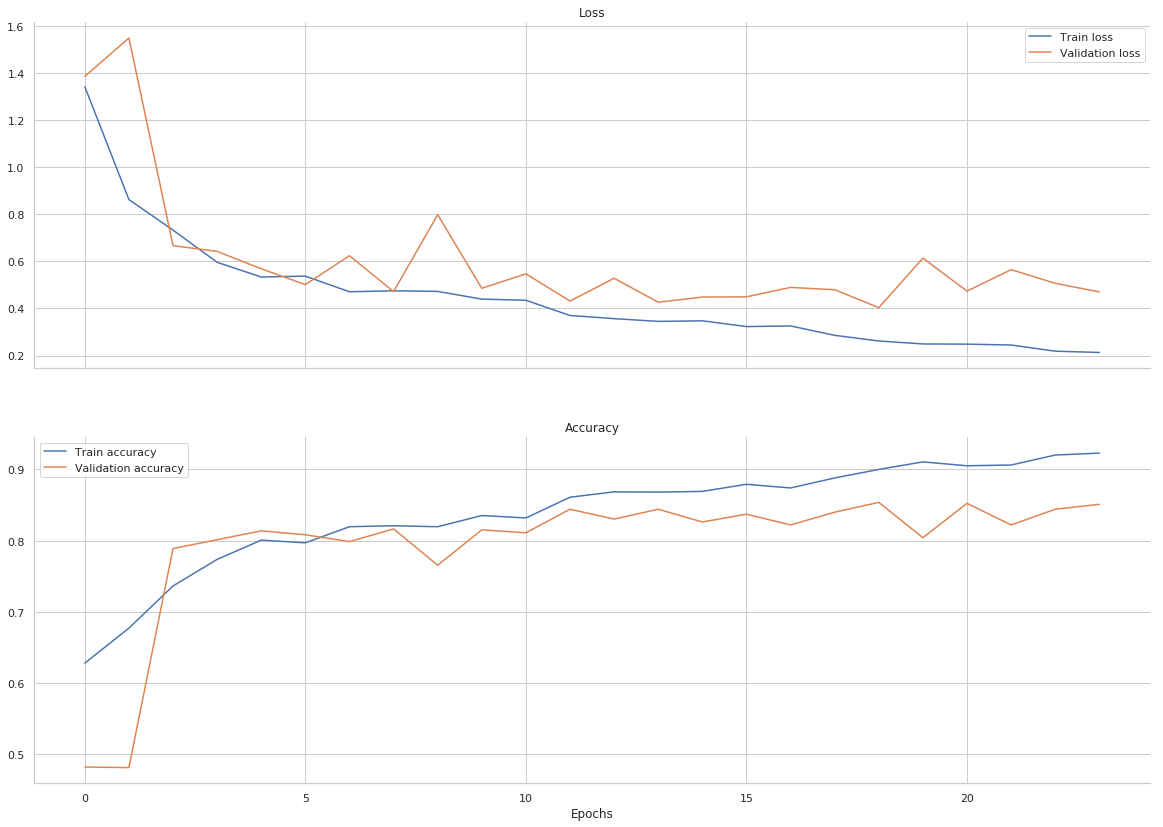

In [11]:
history = {'loss': history_warmup['loss'] + history_finetunning['loss'], 
           'val_loss': history_warmup['val_loss'] + history_finetunning['val_loss'], 
           'acc': history_warmup['acc'] + history_finetunning['acc'], 
           'val_acc': history_warmup['val_acc'] + history_finetunning['val_acc']}

sns.set_style("whitegrid")
fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col', figsize=(20, 14))

ax1.plot(history['loss'], label='Train loss')
ax1.plot(history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history['acc'], label='Train accuracy')
ax2.plot(history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

# Model Evaluation

## Confusion Matrix

In [12]:
# Create empty arays to keep the predictions and labels
lastFullTrainPred = np.empty((0, N_CLASSES))
lastFullTrainLabels = np.empty((0, N_CLASSES))
lastFullValPred = np.empty((0, N_CLASSES))
lastFullValLabels = np.empty((0, N_CLASSES))

# Add train predictions and labels
for i in range(STEP_SIZE_TRAIN+1):
    im, lbl = next(train_generator)
    scores = model.predict(im, batch_size=train_generator.batch_size)
    lastFullTrainPred = np.append(lastFullTrainPred, scores, axis=0)
    lastFullTrainLabels = np.append(lastFullTrainLabels, lbl, axis=0)

# Add validation predictions and labels
for i in range(STEP_SIZE_VALID+1):
    im, lbl = next(valid_generator)
    scores = model.predict(im, batch_size=valid_generator.batch_size)
    lastFullValPred = np.append(lastFullValPred, scores, axis=0)
    lastFullValLabels = np.append(lastFullValLabels, lbl, axis=0)
    
    
lastFullComPred = np.concatenate((lastFullTrainPred, lastFullValPred))
lastFullComLabels = np.concatenate((lastFullTrainLabels, lastFullValLabels))
complete_labels = [np.argmax(label) for label in lastFullComLabels]

train_preds = [np.argmax(pred) for pred in lastFullTrainPred]
train_labels = [np.argmax(label) for label in lastFullTrainLabels]
validation_preds = [np.argmax(pred) for pred in lastFullValPred]
validation_labels = [np.argmax(label) for label in lastFullValLabels]

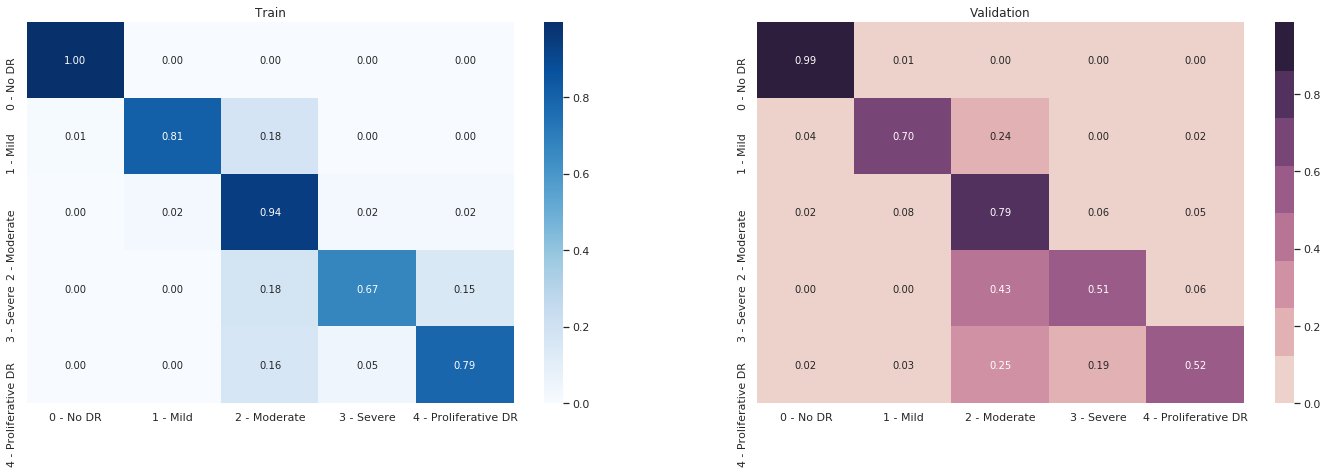

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', figsize=(24, 7))
labels = ['0 - No DR', '1 - Mild', '2 - Moderate', '3 - Severe', '4 - Proliferative DR']
train_cnf_matrix = confusion_matrix(train_labels, train_preds)
validation_cnf_matrix = confusion_matrix(validation_labels, validation_preds)

train_cnf_matrix_norm = train_cnf_matrix.astype('float') / train_cnf_matrix.sum(axis=1)[:, np.newaxis]
validation_cnf_matrix_norm = validation_cnf_matrix.astype('float') / validation_cnf_matrix.sum(axis=1)[:, np.newaxis]

train_df_cm = pd.DataFrame(train_cnf_matrix_norm, index=labels, columns=labels)
validation_df_cm = pd.DataFrame(validation_cnf_matrix_norm, index=labels, columns=labels)

sns.heatmap(train_df_cm, annot=True, fmt='.2f', cmap="Blues", ax=ax1).set_title('Train')
sns.heatmap(validation_df_cm, annot=True, fmt='.2f', cmap=sns.cubehelix_palette(8), ax=ax2).set_title('Validation')
plt.show()

## Quadratic Weighted Kappa

In [14]:
print("Train Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds,train_labels, weights='quadratic'))
print("Validation Cohen Kappa score: %.3f" % cohen_kappa_score(validation_preds, validation_labels, weights='quadratic'))
print("Complete set Cohen Kappa score: %.3f" % cohen_kappa_score(train_preds+validation_preds, train_labels+validation_labels, weights='quadratic'))

Train Cohen Kappa score: 0.960
Validation Cohen Kappa score: 0.894
Complete set Cohen Kappa score: 0.947


# SHAP Model explainability

#### About SHAP's DeepExplainer from the [source repository](https://github.com/slundberg/shap#deep-learning-example-with-deepexplainer-tensorflowkeras-models): 
- Deep SHAP is a high-speed approximation algorithm for SHAP values in deep learning models that builds on a connection with [DeepLIFT](https://arxiv.org/abs/1704.02685) described in the SHAP NIPS paper. The implementation here differs from the original DeepLIFT by using a distribution of background samples instead of a single reference value, and using Shapley equations to linearize components such as max, softmax, products, divisions, etc.

### First let's see the images that we will explain

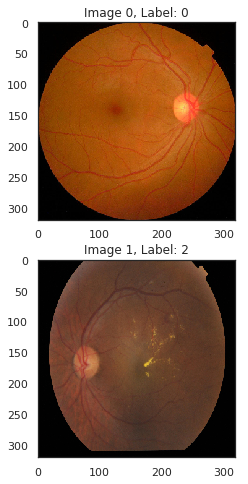

In [15]:
n_explain = 2
valid_generator.batch_size = 10 # background dataset
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[8, 8])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

### Now the SHAP explanation

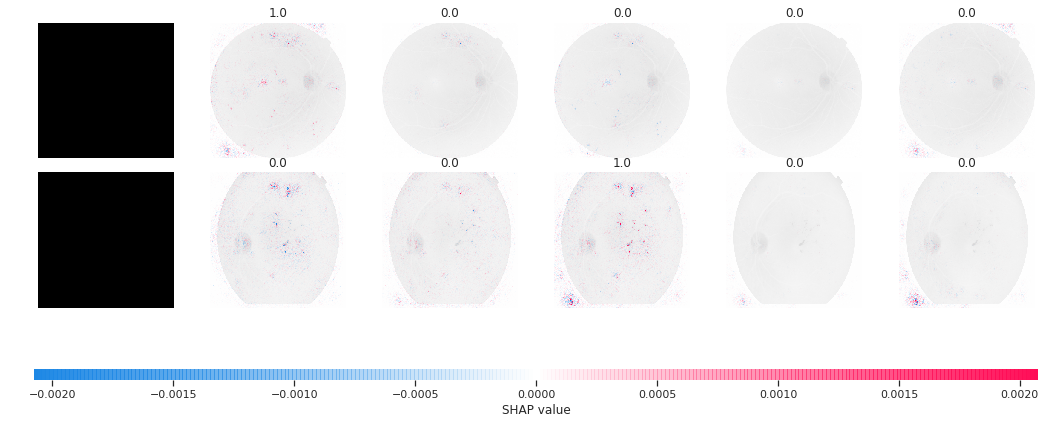

In [16]:
# explain predictions of the model on "n_explain" images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

- The plot above explains five outputs (our five levels of diabetic retinopathy 0-5) for three different images. Red pixels increase the model's output while blue pixels decrease the output. The input images are shown on the left (they are black because most of the pixels are greater than 0), and as nearly transparent grayscale backings behind each of the explanations. The sum of the SHAP values equals the difference between the expected model output (averaged over the background dataset, here I'm using 10 images) and the current model output. 
- Note that for the images that the label is "1.0" (the correct one), we a greater pink area.
- Labels that have as much pink area as the correct one are labels that our model probably doesn't have a high confidence prediction.

## Let's try on a few more images

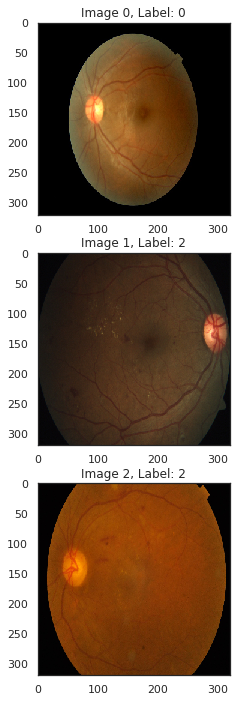

In [17]:
n_explain = 3
background, lbls = next(valid_generator)

sns.set_style("white")
plt.figure(figsize=[12, 12])
for index, image in enumerate(background[:n_explain]):
    plt.subplot(n_explain, 1, index+1)
    plt.imshow(image)
    plt.title("Image %s, Label: %s" % (index, np.argmax(lbls[index])))
    
plt.show()

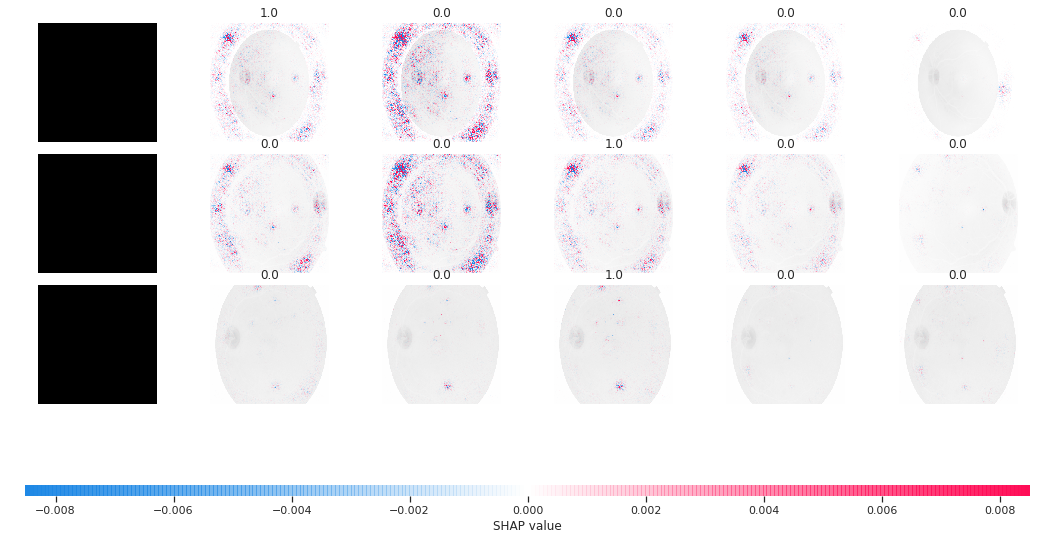

In [18]:
# explain predictions of the model on "n_explain" images
e = shap.DeepExplainer(model, background)
shap_values = e.shap_values(background)

# plot the feature attributions
shap.image_plot(shap_values, -background[:n_explain], labels=lbls, hspace=0.1)

## Apply model to test set and output predictions

In [19]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
preds = model.predict_generator(test_generator, steps=STEP_SIZE_TEST)
predictions = [np.argmax(pred) for pred in preds]

filenames = test_generator.filenames
results = pd.DataFrame({'id_code':filenames, 'diagnosis':predictions})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])

# Predictions class distribution

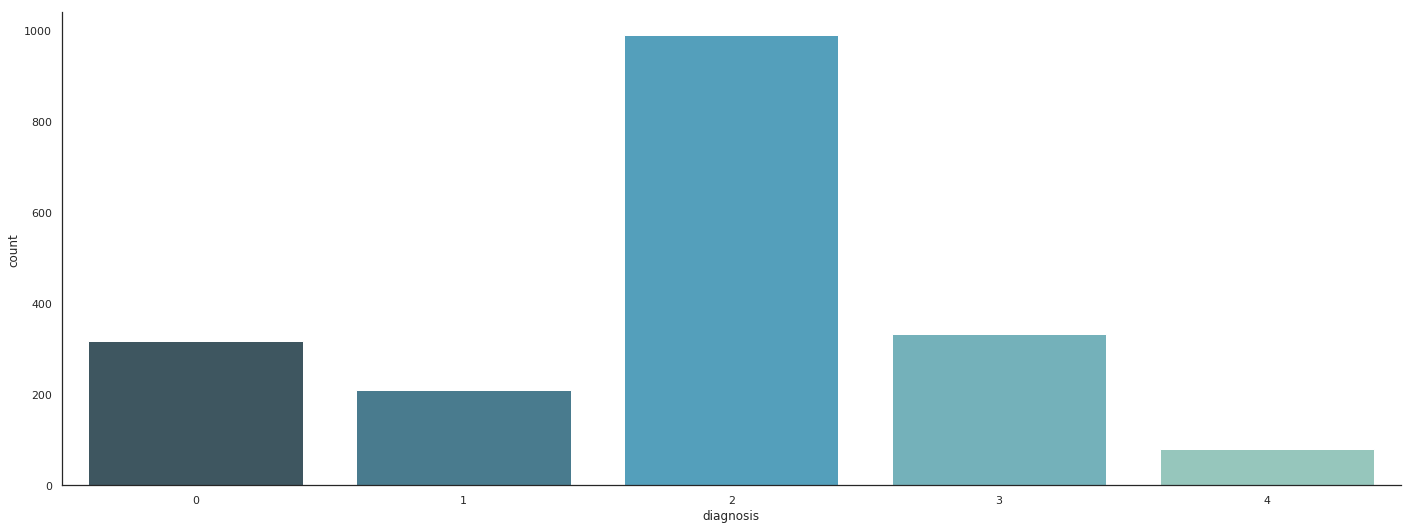

In [20]:
fig = plt.subplots(1, 1, sharex='col', figsize=(24, 8.7))
sns.countplot(x="diagnosis", data=results, palette="GnBu_d")
sns.despine()
plt.show()

In [21]:
results.to_csv('submission.csv', index=False)
results.head(10)

,id_code,diagnosis
0,0005cfc8afb6,2
1,003f0afdcd15,3
2,006efc72b638,3
3,00836aaacf06,2
4,009245722fa4,3
5,009c019a7309,2
6,010d915e229a,3
7,0111b949947e,1
8,01499815e469,3
9,0167076e7089,0
